*HAMMOUTI Douae*

For this notebook a GPU environment is recomended, you could use the Nvidia T4 GPU provided by the Google Colab free plan (but keep in mind terms of service and limitations).

## Transformers

In this exercise session, we will implement a small Transformer model, encoder-only, for a classification task. For pedagogical reasons we will implement the encoder almost from stratch, learning how the components are integrated together. Then, in the second part, we will move to the Huggingface library using pre-trained models and applying a more standard pipeline: take a model pre-trained on a large scale dataset and finetune it on a specific task, updating only a smaller part of model parameters.

In [1]:
!pip install torch 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm

from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
!pip install datasets

For this tutorial we will use the Large Movie Review Dataset for binary sentiment classification with 50k annotated movie reviews. The dataset, available on Huggingface Hub, is splitted in `train` (25k), `test` (25k) and additional unlabeled data as well (`unsupervised`)

In [4]:
from datasets import load_dataset

ds = load_dataset("stanfordnlp/imdb")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


For our purposes this dataset is even too big, therefore we will use on a small sample with 5k reviews taken from the original training set

For every entry in the dataset we have the raw text and the sentiment label (negative=0, positive=1)

In [5]:
IMDB_DF = pd.DataFrame({'review':ds['train']['text'], 'sentiment':ds['train']['label']})
IMDB_DF = IMDB_DF.sample(5000, random_state=42)
IMDB_DF.head()

,review,sentiment
6868,"Dumb is as dumb does, in this thoroughly unint...",0
24016,I dug out from my garage some old musicals and...,1
9668,After watching this movie I was honestly disap...,0
13640,This movie was nominated for best picture but ...,1
14018,Just like Al Gore shook us up with his painful...,1


Let's see an example where it is possible to appreciate the presence of html tags in the text

In [6]:
IMDB_DF['review'].iloc[2]

'After watching this movie I was honestly disappointed - not because of the actors, story or directing - I was disappointed by this film advertisements.<br /><br />The trailers were suggesting that the battalion "have chosen the third way out" other than surrender or die (Polish infos were even misguiding that they had the choice between being killed by own artillery or German guns, they even translated the title wrong as "misplaced battalion"). This have tickled the right spot and I bought the movie.<br /><br />The disappointment started when I realized that the third way is to just sit down and count dead bodies followed by sitting down and counting dead bodies... Then I began to think "hey, this story can\'t be that simple... I bet this clever officer will find some cunning way to save what left of his troops". Well, he didn\'t, they were just sitting and waiting for something to happen. And so was I.<br /><br />The story was based on real events of World War I, so the writers could

Before analysing the data therefore we need to perform some preprocessing, in particular lowercasing the text, HTML tags and URLs removal.

In [7]:
import re
import string
from nltk.tokenize import word_tokenize as tokenizer
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

def imdb_preprocess(review: str) -> str:
    '''
    args:
        review: the string of text containing the movie review
    output:
        the preprocessed string of text
    '''

    # Your code here
    # remove HTML tags and URLs
    # lowercase
    # put your results into a variable named 'lowercased'
    review = re.sub(r'<.*?>', ' ', review)
    review = re.sub(r'http\S+|www\S+|https\S+', ' ', review, flags=re.MULTILINE)
    lowercased = review.lower() 
    

    # remove numbers and symbols
    tokenized_words = tokenizer(lowercased)
    words_alpha = [''.join(this_char for this_char in this_string if (this_char in string.ascii_lowercase)) for this_string in tokenized_words]
    words_alpha = list(filter(None, words_alpha))
    text = ' '.join(words_alpha)
    return text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\douae\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\douae\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
# Your code here
# apply the imdb_preprocess function to the dataframe creating a new column named 'text'
IMDB_DF['text'] = IMDB_DF['review'].apply(imdb_preprocess)

# print the 3rd review and its corresponding preprocessed text  


print(IMDB_DF.iloc[2]['review']+'\n\n'+IMDB_DF.iloc[2]['text'])

After watching this movie I was honestly disappointed - not because of the actors, story or directing - I was disappointed by this film advertisements.<br /><br />The trailers were suggesting that the battalion "have chosen the third way out" other than surrender or die (Polish infos were even misguiding that they had the choice between being killed by own artillery or German guns, they even translated the title wrong as "misplaced battalion"). This have tickled the right spot and I bought the movie.<br /><br />The disappointment started when I realized that the third way is to just sit down and count dead bodies followed by sitting down and counting dead bodies... Then I began to think "hey, this story can't be that simple... I bet this clever officer will find some cunning way to save what left of his troops". Well, he didn't, they were just sitting and waiting for something to happen. And so was I.<br /><br />The story was based on real events of World War I, so the writers couldn't

Now, since we are training everything from scratch with a custom design, we need to implement the tokenizer too, and before that define the vocabulary.

The vocabulary is composed by the words we met during the training with additional "special tokens", in particular \<cls\> (Classify Token),  \<eos\> (End Of Sentence) and  \<pad\> (Padding).

The CLS will define the beginning of the sequence and could be used for classification tasks, being it a representation of the entire sequence. The EOS tag instead will delimit the end of a sentence. PAD represents the padded tokens needed to stack multiple tensors in the batch.

With the `token2index`and `index2token`dictionaries we can perform the convertion between term and vocabulary index and vice versa.

In [9]:
CLS_token = '<cls>'
EOS_token = '<eos>'
PAD_token = '<pad>'
CLS_index = 1
EOS_index = 2
PAD_index = 0

class Vocab:
    def __init__(self):
        self.token2index = {'<pad>':0, '<cls>':1, '<eos>':2}
        self.token2count = {}
        self.index2token = {0: '<pad>', 1: '<cls>', 2: '<eos>'}
        self.vocab_size = 3  # PAD, CLS and EOS

    def __len__(self):
        return self.vocab_size

    def add_sentence(self, sentence, tokenizer):
      for token in tokenizer(sentence):
          self.add_word(token)

    def add_word(self, token):
      if token not in self.token2index:
          self.token2index[token] = self.vocab_size
          self.token2count[token] = 1
          self.index2token[self.vocab_size] = token
          self.vocab_size += 1
      else:
          self.token2count[token] += 1

vocab = Vocab()

for i, tab in tqdm(IMDB_DF.iterrows(), total=len(IMDB_DF)):
  vocab.add_sentence(tab['text'], tokenizer)

print('Vocabulary length: ' + str(len(vocab)))

100%|██████████| 5000/5000 [00:05<00:00, 919.88it/s]

Vocabulary length: 43077


We should have 48959 words in our vocabulary.

Let's see a small example, converting 'hello' to an index and the way back

In [10]:
print(vocab.token2index['hello'])
print(vocab.index2token[4295])

4227
region


Because of the positional embedding in the Transformer architecture, the model can only accept in input a sequence limited in length. During the tokenization process we must keep this in mind, truncating the sentence if needed.

In [ ]:
MAX_LEN = 256

def tokenize(text, tokenizer, vocab) -> list[int]:
    # Tokenize the text
    tokens = tokenizer(text)

    token_ids = [
        vocab.token2index[token] if token in vocab.token2index else vocab.token2index['<pad>']
        for token in tokens
    ]
    token_ids = token_ids[:MAX_LEN - 2]
    token_ids = [vocab.token2index['<cls>']] + token_ids + [vocab.token2index['<eos>']]
    token_ids = token_ids[:MAX_LEN - 2]

    return token_ids


# ✅ Tests
assert(
    tokenize(imdb_preprocess(IMDB_DF.iloc[0]['text']), tokenizer, vocab)[1:11]
    == [3, 4, 5, 3, 6, 7, 8, 9, 10, 11]
)
assert(len(tokenize(imdb_preprocess('hello ' * 300), tokenizer, vocab)) == 254)


And now we create a custom Pytorch Dataset returning a tuple composed by the input sequence and the label

In [18]:
class IMDBReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, vocab):
        self.data = dataframe['text']
        self.labels = dataframe['sentiment']
        self.tokenizer = tokenizer
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = tokenize(self.data.iloc[idx], tokenizer, vocab)
        y = self.labels.iloc[idx]
        return x, y

now we instantiate a new IMDBReviewDataset object and split the dataset into 'train_dataset', 'val_dataset' and 'test_dataset' with 80% - 10% - 10% ratios.


In [19]:
imdb_dataset = IMDBReviewDataset(IMDB_DF, tokenizer, vocab)
train_dataset, val_dataset, test_dataset = random_split(imdb_dataset, [0.8, 0.1, 0.1], generator=torch.Generator())

print('Size of train_dataset: ', len(train_dataset))
print('Size of val_dataset: ', len(val_dataset))
print('Size of test_dataset: ', len(test_dataset))
print()
x, y = train_dataset[0]
print(x)
print(y)

Size of train_dataset:  4000
Size of val_dataset:  500
Size of test_dataset:  500

[1, 7139, 21, 23, 1924, 41791, 105, 92, 481, 482, 86, 1619, 489, 71, 613, 5680, 921, 100, 1526, 23, 16536, 4588, 41, 32639, 1651, 110, 4737, 949, 197, 32, 5912, 166, 2417, 41, 921, 100, 1478, 33, 1189, 1178, 667, 193, 126, 2337, 7, 41792, 18812, 33, 3089, 952, 3828, 2135, 86, 36, 226, 79, 535, 36, 8, 353, 126, 6, 241, 195, 23, 1968, 21, 1896, 369, 921, 100, 4, 33, 197, 86, 673, 694, 188, 41, 5680, 498, 2217, 96, 481, 482, 69, 33, 746, 1140, 86, 1149, 92, 1369, 27751, 4, 7821, 33, 793, 143, 41793, 33, 2442, 4, 6833, 41794, 86, 323, 69, 7063, 716, 6069, 7432, 33, 273, 2531, 4, 23, 41795, 794, 510, 34762, 4402, 209, 23, 41796, 27751, 86, 23, 41797, 1651, 86, 33, 22976, 2074, 2531, 753, 158, 380, 41, 33, 273, 2531, 33, 15526, 3316, 5, 77, 5, 4529, 41798, 86, 23, 339, 4801, 12543, 14516, 143, 13091, 123, 444, 1053, 142, 3387, 83, 2961, 6159, 86, 673, 86, 1053, 323, 69, 29, 692, 2136, 1208, 1434, 33, 5234, 2]


It's time now to add the special tokens to the sequence, CLS at the beginning and EOS at the end.

In [20]:
tokens = [5,6,7]
# Your code here
# using this list as an example
# concatenate CLS, tokens and EOS into a single torch tensor named 'input'
input = torch.Tensor([CLS_index] + tokens + [EOS_index])    


print('Before ',tokens)
print('After: ',input)
assert(torch.equal(input, torch.Tensor([1,5,6,7,2])))

Before  [5, 6, 7]
After:  tensor([1., 5., 6., 7., 2.])


Finally we can create the batches used for the training, the data collator used by the DataLoader will provide us a list of samples to form a batch, given the desired batch size. We just need to implement the callable function to process the batch. To be able to stack multiple tensors together some padding is required, and consequently a padding mask to indicate on which token we should compute the attention. Pads are in fact excluded from the attention computation, whereas CLS and EOS are included

In [34]:
from torch.nn.utils.rnn import pad_sequence

def generate_batch(data_batch):
    '''
    args:
        data_batch: list of N samples, with N being the batch size
    outputs:
        input_ids: tensor with shape N,L containing the token ids, with L the sequence length
        labels: tensor with shape N,1 contaning the labels
        mask: tensor with shape N,L representing the padding mask, indicating if the corresponding token is padding (mask == True) or not
    '''
    input_ids = []
    labels = []
    for tokens, label in data_batch:
        # Add <cls> and <eos> tokens and convert to LongTensor
        input = torch.tensor(tokens, dtype=torch.long)
        label32 = torch.tensor(label, dtype=torch.float32)

        input_ids.append(input)
        labels.append(label32)

    # Pad all sequences to same length
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=PAD_index)
    labels = torch.stack(labels).unsqueeze(1)

    # Create a mask for padding positions
    mask = input_ids == PAD_index

    return input_ids, labels, mask


Let's test the function before moving on...

In [35]:
# example of batch containing sequences with different lengths and the corresponding labels
example = [
    ([5,6,7,8], 0),
    ([4,9], 1)
]

input_ids, labels, mask = generate_batch(example)
print('input_ids: ',input_ids)
print('labels: ',labels)
print('mask: ',mask)

assert(torch.equal(labels, torch.Tensor([[0.],[1.]])))

input_ids:  tensor([[5, 6, 7, 8],
        [4, 9, 0, 0]])
labels:  tensor([[0.],
        [1.]])
mask:  tensor([[False, False, False, False],
        [False, False,  True,  True]])


We expect to see tensors with the same dimensions and 0 pad tokens if needed (0 is the corresponding value in our vocabulary for the PAD token)


We now have everything we need to create the data loaders

In [36]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                       shuffle=False, collate_fn=generate_batch)

For convenience, and taking inspiration from good pratices, we could group all the network hyper-parameters into a single class and then use this to instantiate our model.

We will also use CUDA (if available) to speed up the training.

In [37]:
class Config:
    embd_pdrop = 0.2
    resid_pdrop = 0.2
    attn_pdrop = 0.2
    head_pdrop = 0.2
    n_layer = 6
    n_head = 8
    n_embd = 512
    max_len = MAX_LEN

    def __init__(self, vocab_size):
        setattr(self, 'vocab_size', vocab_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = Config(len(vocab))

It's time now to implement the attention block at the heart of the Transformer architecture. In the `__init__()` function we initialize all the components needed, in particulare the multi head attention. Two other methods (`_sa_block` and `_ff_block`) will deal with self attention and multi layer perceptron.

More in detail, the block is composed by:

1. the self-attention, implemented with PyTorch's `MultiheadAttention`, residual connection and layer normalization
2. a feed forward network with residual connection and layer normalization

We will also use dropout between the different components.

Refer to the official documentation at [https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) to complete this exercise.

<img src="https://www.researchgate.net/publication/336224014/figure/fig1/AS:809717848891393@1570063187530/The-structure-of-a-Transformer-Block.ppm" height="400">

In [38]:
class Block(nn.Module):
    def __init__(self, config):
      super().__init__()
      self.norm1 = nn.LayerNorm(config.n_embd)
      self.norm2 = nn.LayerNorm(config.n_embd)
      self.attn = nn.MultiheadAttention(config.n_embd, config.n_head, batch_first=True)
      self.attn_drop = nn.Dropout(config.attn_pdrop)
      self.linear1 = nn.Linear(config.n_embd, 4 * config.n_embd)
      self.linear_drop = nn.Dropout(config.resid_pdrop)
      self.activation = nn.GELU()
      self.linear2 = nn.Linear(4 * config.n_embd, config.n_embd)
      self.linear_drop2 = nn.Dropout(config.resid_pdrop)

    def forward(self, x:Tensor, msk:Tensor) -> Tensor:
      x = self.norm1(x + self._sa_block(x, msk))
      x = self.norm2(x + self._ff_block(x))
      return x

    def _sa_block(self, x:Tensor, pad_mask:Tensor) -> Tensor:
      # Your code here
      # implement the self attention mechanism with the followin steps:
      # 1. fill the arguments needed for the self.attn component (instance of nn.MultiheadAttention)
      # 2. add dropout by calling self.attn_drop (instance of nn.Dropout)
      attn_output, _ = self.attn(x, x, x, key_padding_mask=pad_mask)
      attn_output = self.attn_drop(attn_output)
      return attn_output

    def _ff_block(self, x:Tensor) -> Tensor:
      x = self.linear2(self.linear_drop(self.activation(self.linear1(x))))
      return self.linear_drop2(x)

**How are residual connections implemented in this code? In which lines?**

*sidual connections (also called skip connections) mean that we add the input of a sublayer to its output before normalizing or passing further.*

*residual connections are implemented on lines:

      x = self.norm1(x + self._sa_block(x, msk))

      x = self.norm2(x + self._ff_block(x))* 


*These make sure gradients flow better and that each block learns a refinement of its input rather than a completely new transformation.*

**How is the feed forward network implemented? How many levels and with what dimensions?**

*The feed-forward network is implemented in the _ff_block() method.

It has 2 linear layers with dimensions 512 → 2048 → 512, using a GELU activation and dropout between them.*

Until now we just converted words (strings of text) into indeces by looking at the corresponding token index in the vocabulary. Now, with this neural network, we should move to an higher space dimension, converting indeces into embeddings. You can think of this first layer as a lookup table, that will retrieve the corresponding (learnable) embedding given the token index.

Look at the documentation for more info [https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

In [39]:
# Your code here
# instantiate an embedding lookup table with as many entries as our vocabulary and embeddings size equal to config.n_embd
emb = nn.Embedding(config.vocab_size, config.n_embd)

embedding = emb(torch.Tensor([1,2,3,4,5,6,7,8,9,0]).long())
print(embedding)
print(embedding.shape)

assert(embedding.shape == torch.Size([10, 512]))

tensor([[ 1.4337, -1.4741, -0.1260,  ...,  0.7362, -1.7791, -1.4085],
        [ 0.0522,  0.0288, -0.3778,  ..., -0.4391, -1.7846, -1.7391],
        [-0.7459, -0.2971,  0.8417,  ...,  1.4472,  0.4817, -0.9211],
        ...,
        [-0.4470, -0.1089, -1.0322,  ..., -3.1458,  0.4758, -0.1635],
        [-1.5991,  0.5467,  0.3216,  ..., -0.3729, -0.2741,  1.4558],
        [ 0.4416,  0.7609,  0.8655,  ..., -1.2192, -0.6141,  0.4698]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([10, 512])


As we have seen, the attention mechanism is permutation equivariant, meaning that it does not take into account the order of the elements. In NLP, though, the word order is important. In this implementation we will use learnable positional embeddings.

In [40]:
# Your code here
# instantiate an embedding layer with config.max_len entries and same embeddings size as before
pos_emb =   nn.Embedding(config.max_len, config.n_embd)

# the input of this model consists of a sequence of ordered numbers spanning from 0 to the lenght of the sequence to encode
input_pos = torch.arange(12, dtype=torch.long)
print(input_pos)

# the result of applying the positional embedding layer to the input is just another set of (learnable) embeddings
embs = pos_emb(input_pos)
print(embs)

# with shape L,E where L is the sequence lenght and E the embedding size
print(embs.shape)
assert(embs.shape == torch.Size([12, 512]))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
tensor([[ 0.2179, -1.1469, -0.5738,  ..., -1.7345, -0.9270, -2.5553],
        [ 0.5729,  0.5867,  1.0441,  ...,  1.2253,  0.7463, -1.2076],
        [-0.1359, -0.0544, -1.2718,  ..., -0.0752, -0.2488,  0.4072],
        ...,
        [-0.2880, -0.4251,  0.2210,  ..., -0.4282, -1.4895,  0.4274],
        [-0.0512,  0.1810, -1.4433,  ...,  1.2636,  0.1479, -0.7344],
        [ 0.0183, -0.0409,  1.3849,  ..., -0.4262, -0.3117, -1.6138]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([12, 512])


With these components we can finally build the Transformer encoder to be used as classifier. To this aim we will add a "classification head" at the end, composed by a simple linear layer.

The Transformer model is a sequence-to-sequence architecture, meaning that from a input sequence of length L it will return another sequence with the same length. For classification tasks, thought, it's sufficient to take the CLS embedding as representation for the entire sequence, and performing classification on that. \(Other popular strategies could involve max pooling of average pooling over the sequence\). In this case we will simply apply the classification head to the CLS embedding, that is the first embedding of the sequence.

In [41]:
class EncoderClassifier(nn.Module):
    def __init__(self, config):
        super(EncoderClassifier, self).__init__()
        # Your code here
        # instantiate your embedding layer for converting input tokens into embedding vectors
        self.emb = emb

        # Your code here
        # instantiate your positional embedding layer
        self.pos_emb = pos_emb

        self.norm_emb = nn.LayerNorm(config.n_embd)
        self.drop_emb = nn.Dropout(config.embd_pdrop)

        # repeat the Block module 'n_layer' times
        self.blocks = nn.ModuleList(Block(config) for _ in range(config.n_layer))

        # classification head
        self.class_head = nn.Linear(config.n_embd, 1)
        self.drop_head = nn.Dropout(config.head_pdrop)

        self._init_weights()

    def forward(self, x:Tensor, msk:Tensor) -> Tensor:
        device = x.device

        x = self.emb(x)  # N, L, E
        position_ids = torch.arange(x.size(1), dtype=torch.long).unsqueeze(0).to(device)  # 1, L
        pos_emb = self.pos_emb(position_ids)  # 1, L, E
        x = x + pos_emb  # N, L, E
        x = self.drop_emb(self.norm_emb(x))

        for block in self.blocks:
            x = block(x, msk)

        # Your code here
        # given the output of the network x with shape (N,L,E)
        # get the embedding corresponding to the CLS token (the first of the sequence)
        # the output shape should be (N,E)
        pooled = x[:, 0]

        out = self.class_head(self.drop_head(pooled))
        return out

    def _init_weights(self):
        # weights initialization
        self.emb.weight.data.uniform_(-0.1, 0.1)
        self.class_head.weight.data.uniform_(-0.1, 0.1)


Now that the implementation is ready we can instantiate the model and load it into memory

In [42]:
model = EncoderClassifier(config).to(device)
print(model)

EncoderClassifier(
  (emb): Embedding(43077, 512)
  (pos_emb): Embedding(256, 512)
  (norm_emb): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (drop_emb): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (attn_drop): Dropout(p=0.2, inplace=False)
      (linear1): Linear(in_features=512, out_features=2048, bias=True)
      (linear_drop): Dropout(p=0.2, inplace=False)
      (activation): GELU(approximate='none')
      (linear2): Linear(in_features=2048, out_features=512, bias=True)
      (linear_drop2): Dropout(p=0.2, inplace=False)
    )
  )
  (class_head): Linear(in_features=512, out_features=1, bias=True)
  (drop_head): Dropout(p=0.2, inplace=False)
)


For this simple training we will use the Adam optimizer and Binary Cross Entropy loss. In particular we rely on the nn.BCEWithLogitsLoss loss that includes a sigmoid function inside, meaning that - as the name suggests - we can use directly the logits (output) of the network as input

In [43]:
LR = 1e-5

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

Here our training loop:

In [44]:
def train(model, trainloader, optimizer, criterion, device):
    print('Training')
    model.train()
    loss_epoch = 0

    for inputs, labels, masks in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(inputs, masks)

        # Calculate the loss
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss_epoch += loss.item()

        # Backpropagation
        loss.backward()

        # Update the optimizer parameters
        optimizer.step()

    return loss_epoch/len(trainloader)

For the evaluation phase, instead, we don't need to compute the gradients and perform backpropagation, we just need to run the model, compute and store the loss.

In [45]:
def validate(model, testloader, criterion, device):
    print('Validation')
    loss_epoch = 0

    # Your code here
    # implement your validation loop keeping in mind to 1) put the model into evaluation mode and 2) disable gradient computation
    model.eval()
    with torch.no_grad():
        for inputs, labels, masks in tqdm(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(inputs, masks)
            loss = criterion(outputs, labels)
            loss_epoch += loss.item()

    return loss_epoch/len(testloader)

Finally we can start the training, be aware that it could take a while.

For this toy example we will limit the training to 4 epochs, monitoring the training and validation losses. If the validation loss is improving we will save the model on the disk for future use

In [46]:
EPOCHS = 4

train_loss, valid_loss = [], []
least_loss = float('inf')

for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")

    train_epoch_loss = train(model, train_loader, optimizer, criterion, device)
    valid_epoch_loss = validate(model, valid_loader, criterion, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Training loss: {train_epoch_loss}")
    print(f"Validation loss: {valid_epoch_loss}")

    # Save model
    if valid_epoch_loss < least_loss:
        least_loss = valid_epoch_loss
        print(f"Saving best model till now...")
        torch.save(model, 'model.pth')

    print('-'*50)

[INFO]: Epoch 1 of 4
Training


100%|██████████| 63/63 [14:50<00:00, 14.13s/it]


Validation


100%|██████████| 8/8 [00:23<00:00,  2.93s/it]


Training loss: 0.810758268076276
Validation loss: 0.694878563284874
Saving best model till now...
--------------------------------------------------
[INFO]: Epoch 2 of 4
Training


100%|██████████| 63/63 [17:05<00:00, 16.28s/it]


Validation


100%|██████████| 8/8 [00:31<00:00,  3.89s/it]


Training loss: 0.7735601578439985
Validation loss: 0.6915351301431656
Saving best model till now...
--------------------------------------------------
[INFO]: Epoch 3 of 4
Training


100%|██████████| 63/63 [18:38<00:00, 17.76s/it]


Validation


100%|██████████| 8/8 [00:22<00:00,  2.77s/it]


Training loss: 0.7745105860725282
Validation loss: 0.713542141020298
--------------------------------------------------
[INFO]: Epoch 4 of 4
Training


100%|██████████| 63/63 [16:26<00:00, 15.66s/it]


Validation


100%|██████████| 8/8 [00:21<00:00,  2.65s/it]


Training loss: 0.7340890916567
Validation loss: 0.688492089509964
Saving best model till now...
--------------------------------------------------


We should not expect great results from training such a small model for only 4 epochs on a toy dataset, but we can still visualize the loss evolution through time.

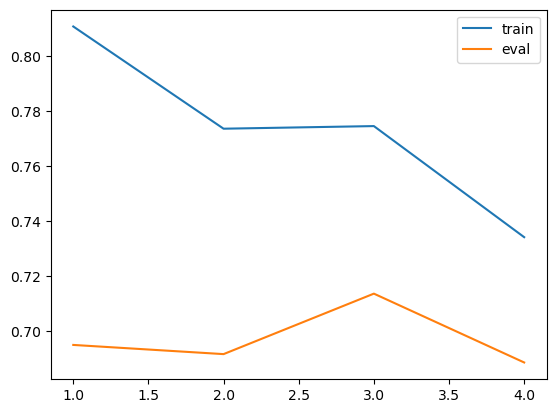

In [47]:
import matplotlib.pyplot as plt

x = [x for x in range(1, EPOCHS+1)]
plt.plot(x, train_loss, label = "train")
plt.plot(x, valid_loss, label = "eval")
plt.legend()
plt.show()

Now that the training is over we can load the best performing model (on the validation set) we saved before

In [48]:
trained_model = torch.load('model.pth', weights_only=False)

And evaluate it on the test set. In this case we will rely on the Scikit-learn library to compute the F1-score.

This time, however, we need to create our predictions from the logits using a sigmoid function. For this purpose we can consider as positive class (1) probabilities that are stricly higher than 0.5 and 0 otherwise.

In [49]:
from sklearn.metrics import f1_score

def test(model, testloader, criterion, device):
    print('Testing')
    model.eval()
    loss_epoch = 0
    f1_scores = 0

    with torch.no_grad():
        for inputs, labels, masks in tqdm(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            masks = masks.to(device)

            outputs = model(inputs, masks)

            loss = criterion(outputs, labels)
            loss_epoch += loss.item()

            # move tensors from GPU (is used) to CPU and flatten the representation
            flatten_x = outputs.view(-1).cpu()
            flatten_y = labels.long().view(-1).cpu()

            # Your code here
            # apply a sigmoid to flatten_x and make your predictions (1 iif prob > 0.5, 0 otherwise)
            # convert the result into a long tensor (pytorch tensor with long type)
            # Hint: use torch.sigmoid()
            preds = (torch.sigmoid(flatten_x) > 0.5).long()

            f1 = f1_score(flatten_y, preds, average='binary')
            f1_scores += f1

    return loss_epoch/len(testloader), f1_scores/len(testloader)

test_loss, f1 = test(trained_model, test_loader, criterion, device)
print('\nTest loss: {}\nF1-score: {}'.format(test_loss, f1))

Testing


100%|██████████| 8/8 [00:21<00:00,  2.71s/it]


Test loss: 0.6942787244915962
F1-score: 0.6329889898826631


## Pretrained models with Huggingface

We just learned how Transformer models work, this could be useful in the future if we want to modify, internally, the architecture, adapting or adding new components. We trained our model from scratch but we could have loaded pre-trained weights if we had them. Doing all this with native PyTorch might not be easy, though.

That's why, for this second part, we will move to the Hugginface library (a de-facto standard when working with Transformers), using its implementations and pre-trained models already available on Hugginface Hub.
We will perform the same classification task but in a much easier way.

Let's download an already pre-processed version of the Large Movie Review Dataset taking only 5k samples from the train split.

For this example we will use only two splits for training and validation respectively

In [50]:
from datasets import load_dataset

imdb = load_dataset("imdb", verification_mode='no_checks', split='train[0:5000]')
imdb = imdb.train_test_split(test_size=0.1)
print(imdb)

README.md: 0.00B [00:00, ?B/s]

c:\Users\douae\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\douae\.cache\huggingface\hub\datasets--imdb. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performa

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
})


Let's use a more advanced subword tokenizer

In [51]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\douae\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\douae\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

**Do you remember any advantages in using a subword tokenizers? What are the main features and why we are using them?**

*Subword tokenizers are used because they handle unknown words by breaking them into smaller known pieces, reduce vocabulary size, and improve model generalization. They balance word- and character-level tokenization, making models more efficient and robust across different words and languages.*

We need to rewrite our collator function by replacing the tokenizer. Notice that this new tokenizer can already do truncation and padding, working directly on a list of texts

In [52]:
def generate_batch(data_batch):
    batch = []
    labels = []
    for data in data_batch:
        batch.append(data['text'])
        labels.append(torch.tensor(data['label']).long())

    batch = tokenizer(batch, truncation=True, padding='longest')
    labels = torch.stack(labels)

    input_ids = torch.tensor(batch['input_ids'])
    attention_mask = torch.tensor(batch['attention_mask'])
    return input_ids, attention_mask, labels

Let's create two data loaders for training and validation sets

In [53]:
BATCH_SIZE = 64

train_loader = DataLoader(imdb['train'], batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=generate_batch)
valid_loader = DataLoader(imdb['test'], batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=generate_batch)

And now we can load the pretrained model; we will use DistilBERT: a ligther version of BERT (fewer parameters) obtained by distilling it (through knowledge distillation). It will make our training faster while preserving good performances.

Take a look at the documentation at [https://huggingface.co/docs/transformers/model_doc/distilbert](https://huggingface.co/docs/transformers/model_doc/distilbert).
You will notice that we are using the `DistilBertForSequenceClassification` model, that is a `DistilBertModel` with a classification head on top. However only the base model is pretrained, the linear classification layers are just randomly initialized (see the warning that appears after loading the model).

In [54]:
from transformers import AutoModelForSequenceClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained('distilbert/distilbert-base-uncased', num_labels=2)
model = model.to(device)
print(model)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


**Based on the printed output, what information we could get from the model? How many layers is it using? What is the internal embedding dimension? And the maximum sequence lenght?**

*From the printed model summary, we can see that:

✅ Model type: DistilBERT (a smaller, faster version of BERT).

✅ Number of Transformer layers: 6 ((0-5): 6 x TransformerBlock).

✅ Embedding dimension: 768 (from Embedding(30522, 768, ...)).

✅ Maximum sequence length: 512 (from position_embeddings: Embedding(512, 768)).

So, the model uses 6 layers, 768 hidden dimensions, and supports sequences up to 512 tokens long.*

Unlike the first part of this notebook, when we trained a new model from scratch, this time we have a pre-trained model with all its benefits. In particular we can rely on previously trained weights that already have a good knowledge of the language and finetune the model on our downstream task (classification in this case).

Moreover, to save computational resources and avoid overfitting, as well as preventing catastrophic forgetting of previously learned features, we can freeze some layers and train only those who are necessary.
When deciding how much of a pre-trained model to fine-tune, there is no definitive answer as it depends on several factors. The similarity between the original task and the new task, the size and complexity of the pre-trained model, as well as the size and quality of the new data all play a role. For example, if the tasks are very similar, you may only need to fine-tune the last layer or the classifier head of the pre-trained model. However, if the tasks are very different or you have a lot of high-quality data for the new task, you can afford to fine-tune more layers or even the whole model.

In this toy example we will freeze all the pre-trained weights from DistillBERT, training only the classification head (final MLP). In PyTorch is very easy to prevent gradient computation, indeed it is sufficient to set the `requires_grad` attribute of a network parameter to `False` to freeze it.

Let's visualize the list of parameters (network weights) of our model

In [55]:
for name, param in model.named_parameters():
    print('Shape: {}\tName: {}'.format(param.shape, name))

Shape: torch.Size([30522, 768])	Name: distilbert.embeddings.word_embeddings.weight
Shape: torch.Size([512, 768])	Name: distilbert.embeddings.position_embeddings.weight
Shape: torch.Size([768])	Name: distilbert.embeddings.LayerNorm.weight
Shape: torch.Size([768])	Name: distilbert.embeddings.LayerNorm.bias
Shape: torch.Size([768, 768])	Name: distilbert.transformer.layer.0.attention.q_lin.weight
Shape: torch.Size([768])	Name: distilbert.transformer.layer.0.attention.q_lin.bias
Shape: torch.Size([768, 768])	Name: distilbert.transformer.layer.0.attention.k_lin.weight
Shape: torch.Size([768])	Name: distilbert.transformer.layer.0.attention.k_lin.bias
Shape: torch.Size([768, 768])	Name: distilbert.transformer.layer.0.attention.v_lin.weight
Shape: torch.Size([768])	Name: distilbert.transformer.layer.0.attention.v_lin.bias
Shape: torch.Size([768, 768])	Name: distilbert.transformer.layer.0.attention.out_lin.weight
Shape: torch.Size([768])	Name: distilbert.transformer.layer.0.attention.out_lin.bia

We will freeze everything but the classification layers, i.e., `pre_classifier`and `classifier` linear layers (both weight and bias).

In [56]:
for name, param in model.named_parameters():
    param.requires_grad = False
    if 'classifier' in name:
        param.requires_grad = True

Let's now collect the parameters we want to train and that will be used by the optimizer

In [57]:
# Your code here
# create a list named 'params' containing only the parameters we want to train
# use list comprehension and rely on the attribute
params = [param for param in model.parameters() if param.requires_grad] 


assert(all([x.requires_grad for x in params]) and len([x.requires_grad for x in params]) == 4)

These parameters will be optimized by the AdamW optimizer based on the cross entropy loss. Please notice that this time the final layer of the network is a linear layer with 2 output features (our two classes), therefore we will rely the (log) softmax already implemented inside `nn.CrossEntropyLoss` to compute the probabilities and the loss.

In [58]:
LR = 1e-5
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params, lr=LR)

Here our training and validation loops, depending on the function parameters, the Huggingface model may return different outputs (e.g., the attention weights, hidden states of the loss). We are only interested to the logits, i.e. the unnormalised predictions (output) for the model.

In [59]:
def train(model, trainloader, optimizer, criterion, device):
    print('Training')
    model.train()
    loss_epoch = 0

    for input_ids, att_mask, labels in tqdm(trainloader):
        input_ids = input_ids.to(device)
        att_mask = att_mask.to(device)
        labels = labels.to(device)

        logits = model(input_ids, att_mask)['logits']

        optimizer.zero_grad()
        loss = criterion(logits, labels)
        loss_epoch += loss.item()
        loss.backward()
        optimizer.step()

    return loss_epoch/len(trainloader)

def validate(model, testloader, criterion, device):
    print('Validation')
    model.eval()
    loss_epoch = 0

    with torch.no_grad():
        for input_ids, att_mask, labels in tqdm(testloader):
            input_ids = input_ids.to(device)
            att_mask = att_mask.to(device)
            labels = labels.to(device)

            logits = model(input_ids, att_mask)['logits']

            loss = criterion(logits, labels)
            loss_epoch += loss.item()

    return loss_epoch/len(testloader)

Finally we can train (finetune) our model over 4 epochs

In [60]:
EPOCHS = 4

train_loss, valid_loss = [], []
least_loss = float('inf')

for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")

    train_epoch_loss = train(model, train_loader, optimizer, criterion, device)
    valid_epoch_loss = validate(model, valid_loader, criterion, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Training loss: {train_epoch_loss}")
    print(f"Validation loss: {valid_epoch_loss}")

    print('-'*50)

[INFO]: Epoch 1 of 4
Training


100%|██████████| 71/71 [39:20<00:00, 33.25s/it]


Validation


100%|██████████| 8/8 [02:01<00:00, 15.18s/it]


Training loss: 0.4604246910189239
Validation loss: 0.28752104565501213
--------------------------------------------------
[INFO]: Epoch 2 of 4
Training


100%|██████████| 71/71 [32:15<00:00, 27.26s/it]


Validation


100%|██████████| 8/8 [02:15<00:00, 16.92s/it]


Training loss: 0.20419943437609875
Validation loss: 0.11778188589960337
--------------------------------------------------
[INFO]: Epoch 3 of 4
Training


100%|██████████| 71/71 [33:14<00:00, 28.09s/it]


Validation


100%|██████████| 8/8 [02:03<00:00, 15.50s/it]


Training loss: 0.0904833663412383
Validation loss: 0.05330787319689989
--------------------------------------------------
[INFO]: Epoch 4 of 4
Training


100%|██████████| 71/71 [30:41<00:00, 25.94s/it]


Validation


100%|██████████| 8/8 [01:53<00:00, 14.21s/it]

Training loss: 0.04569711709316348
Validation loss: 0.028759789653122425
--------------------------------------------------


and visualize the loss

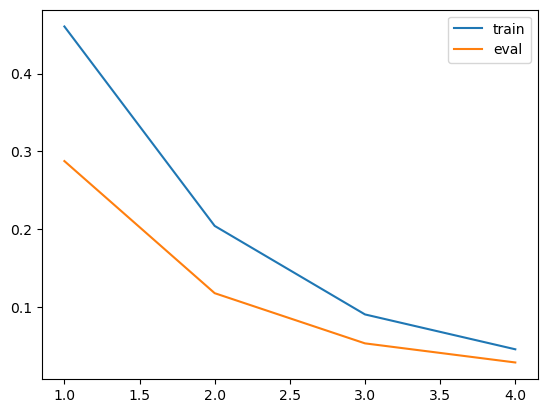

In [61]:
x = [x for x in range(1, EPOCHS+1)]
plt.plot(x, train_loss, label = "train")
plt.plot(x, valid_loss, label = "eval")
plt.legend()
plt.show()

## +++ End of the mandatory section +++

## **Advance only**

Jupyter notebook could be useful for prototyping and testing new ideas, in this tutorial we explored step-by-step how to build a modern NLP classifier. However, once the code is ready and tested, it is convenient to have a native python script ready to run on your enviroment (colab, a virtual machine on the cloud or a cluster).

Try to collect and rewrite the classification pipeline with Huggingface into a single Python script, removing redundant parts and useless variables (sometimes we create new variables just for the explanation). Make the code easy to use and generalizable, for example it should be easy to change the pretrained model if needed for another experiment. Use command line arguments to set the hyper-parameters of the experiments (e.g. learning rate, epochs, batch size etc.). Feel free to experiment with your classifier but be careful of the computational limits you may encounter. Keep in mind that the goal of this lab was to introduce the classification task and familiarize with standard libraries, not to release a new state-of-the-art model.